#Carga de datos

In [0]:
dfPopulation = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/poblacion.csv")

dfPoverty = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/pobreza.csv")

dfArrests = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/arrestos.csv")

dfCrashes = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/colisiones.csv")

df5 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/2016___2017_Health_Education_Report.csv")


#Exploración de los datos

Porcentaje de arrestos según población total por localidad

In [0]:
from pyspark.sql.functions import split,when
import pandas as pd



dfArrests = dfArrests.withColumn("ARREST_BORO",when(dfArrests["ARREST_BORO"] == "K", "Brooklyn").when(dfArrests["ARREST_BORO"] == "B", "Bronx").when(dfArrests["ARREST_BORO"] == "M", "Manhattan").when(dfArrests["ARREST_BORO"] == "Q", "Queens").when(dfArrests["ARREST_BORO"] == "S", "Staten Island").otherwise(dfArrests["ARREST_BORO"]))



dfPopulation2022 = dfPopulation[["Borough","2020","2020 - Boro share of NYC total"]].withColumnRenamed("2020","year2020")
dfPopulation2022 = spark.createDataFrame(dfPopulation2022.tail(dfPopulation2022.count()-1), dfPopulation2022.schema).sort("Borough")
dfPopulation2022 = dfPopulation2022.withColumnRenamed("Borough","ARREST_BORO")

#display(dfPopulation2022)

dfArrestsDate = dfArrests.withColumn('month', split(dfArrests['ARREST_DATE'], '/').getItem(0)) \
       .withColumn('day', split(dfArrests['ARREST_DATE'], '/').getItem(1)) \
       .withColumn('year', split(dfArrests['ARREST_DATE'], '/').getItem(2))

#display(dfArrestsDate)
por_year = dfArrestsDate.groupBy("year").count()
por_boro = dfArrestsDate.groupBy("ARREST_BORO").count().sort("ARREST_BORO")
por_boro = por_boro.withColumnRenamed("count","cantidad")
#display(por_boro)
por_borodf=por_boro.toPandas()
population2022Df= dfPopulation2022.toPandas()

#join=dfPopulation2022.join(por_boro,"ARREST_BORO").select("ARREST_BORO",  (por_boro.cantidad / dfPopulation2022["2020 - Boro share of NYC total"]).alias("product"))

por_borodf["Porcentaje según población total"]= (por_borodf["cantidad"]*100)/population2022Df["year2020"]

percentajePerBorough = spark.createDataFrame(por_borodf) 
display(percentajePerBorough.withColumnRenamed("ARREST_BORO","Arrestos"))


Arrestos,cantidad,Porcentaje según población total
Bronx,21198,1.4651766533866746
Brooklyn,25431,0.960221291531808
Manhattan,22997,1.4037274435826332
Queens,19416,0.83319923014039
Staten Island,4196,0.8613275035666267


Cantidad de arrestos según edad y sexo

In [0]:


dfPeople = dfArrests.groupBy("AGE_GROUP","PERP_SEX").count().sort("AGE_GROUP").withColumnRenamed("PERP_SEX","Género").withColumnRenamed("AGE_GROUP","Rango de edades").withColumnRenamed("count","Cantidad")

display(dfPeople)


Rango de edades,Género,Cantidad
18-24,F,3054
18-24,M,13201
25-44,M,44094
25-44,F,9664
45-64,M,15795
45-64,F,2696
65+,F,212
65+,M,1138
<18,F,643
<18,M,2741


Cantidad de arrestos según raza y sexo

In [0]:
dfPeople2 = dfArrests.groupBy("PERP_RACE","PERP_SEX").count().sort("PERP_RACE").withColumnRenamed("PERP_RACE","Raza").withColumnRenamed("count","Cantidad").withColumnRenamed("PERP_SEX","Género")
display(dfPeople2)

Raza,Género,Cantidad
AMERICAN INDIAN/ALASKAN NATIVE,M,207
AMERICAN INDIAN/ALASKAN NATIVE,F,32
ASIAN / PACIFIC ISLANDER,M,4232
ASIAN / PACIFIC ISLANDER,F,774
BLACK,M,37854
BLACK,F,8260
BLACK HISPANIC,M,7002
BLACK HISPANIC,F,1204
UNKNOWN,M,291
UNKNOWN,F,40


Cantidad de accidentes según tipo de vehículo

In [0]:
from pyspark.sql.functions import split,when,col




porTipoVehículo = dfCrashes.groupBy("VEHICLE_TYPE").count().sort(col("count").desc())
#display(porTipoVehículo.schema)
porTipoVehículo=porTipoVehículo.withColumn("VEHICLE_TYPE",when(col("VEHICLE_TYPE").isNull(), "Sin información").otherwise(porTipoVehículo["VEHICLE_TYPE"])).withColumnRenamed("count","Cantidad").withColumnRenamed("VEHICLE_TYPE","TipoDeVehículo")
porTipoVehículo=porTipoVehículo.head(10)
display(porTipoVehículo)


TipoDeVehículo,Cantidad
PASSENGER VEHICLE,770756
Sedan,653589
Station Wagon/Sport Utility Vehicle,532612
SPORT UTILITY / STATION WAGON,337927
Sin información,120557
UNKNOWN,105357
4 dr sedan,72852
Taxi,69713
TAXI,60785
VAN,49720


Cantidad de accidentes según licencia del conductor

In [0]:
porLicencia = dfCrashes.groupBy("DRIVER_LICENSE_STATUS").count()

porLicencia=porLicencia.withColumn("DRIVER_LICENSE_STATUS",when(col("DRIVER_LICENSE_STATUS").isNull(), "Sin información").otherwise(porLicencia["DRIVER_LICENSE_STATUS"])).withColumnRenamed("DRIVER_LICENSE_STATUS","EstadoDeLaLicenciaDelConductor").withColumnRenamed("count","Cantidad")
display(porLicencia)

EstadoDeLaLicenciaDelConductor,Cantidad
Sin información,1935085
Unlicensed,18995
Permit,7763
Licensed,1235864


Cantidad de accidentes según factor contribuidor

In [0]:
porFactor = dfCrashes.groupBy("CONTRIBUTING_FACTOR_1").count().sort(col("count").desc()).withColumnRenamed("CONTRIBUTING_FACTOR_1","Factor que contribuye")

porFactor=porFactor.withColumn("Factor que contribuye",when(col("Factor que contribuye").isNull(), "Sin información").otherwise(porFactor["Factor que contribuye"])).withColumnRenamed("count","Cantidad")

porFactor=porFactor.head(10)
display(porFactor)

Factor que contribuye,Cantidad
Unspecified,1872007
Driver Inattention/Distraction,371555
Failure to Yield Right-of-Way,105741
Following Too Closely,93570
Sin información,85797
Other Vehicular,79901
Backing Unsafely,68571
Fatigued/Drowsy,59690
Turning Improperly,49183
Passing or Lane Usage Improper,46758


Cantidad de personas consideradas en probreza

In [0]:


porCantidadPobreza=  dfPoverty.groupBy("NYCgov_Pov_Stat").count().withColumnRenamed("NYCgov_Pov_Stat","EstadoDePobreza")

porCantidadPobreza=porCantidadPobreza.withColumn("EstadoDePobreza",when(porCantidadPobreza["EstadoDePobreza"] == "1", "En pobreza").when(porCantidadPobreza["EstadoDePobreza"] == "2", "No en pobreza").otherwise(porCantidadPobreza["EstadoDePobreza"]))
display(porCantidadPobreza)


EstadoDePobreza,count
En pobreza,12113
No en pobreza,56160


Estado laboral de las personas según clasificación en índice de pobreza

In [0]:
porEstadoLaboral=  dfPoverty.groupBy("NYCgov_Pov_Stat","ESR").count().withColumnRenamed("ESR","EstadoLaboral").withColumnRenamed("NYCgov_Pov_Stat","EstadoDePobreza").withColumnRenamed("count","Cantidad").sort("EstadoLaboral")

porEstadoLaboral=porEstadoLaboral.withColumn("EstadoDePobreza",when(porEstadoLaboral["EstadoDePobreza"] == "1", "En pobreza").when(porEstadoLaboral["EstadoDePobreza"] == "2", "No en pobreza").otherwise(porEstadoLaboral["EstadoDePobreza"]))
porEstadoLaboral=porEstadoLaboral.withColumn("EstadoLaboral",when(porEstadoLaboral["EstadoLaboral"] == "1", "EmpleadoConEmpleo").when(porEstadoLaboral["EstadoLaboral"] == "2", "EmpleadoConTrabajoPeroNoEmpleo").when(porEstadoLaboral["EstadoLaboral"] == "3", "Desempleado").when(porEstadoLaboral["EstadoLaboral"] == "4", "FuerzasArmadasEnServicio").when(porEstadoLaboral["EstadoLaboral"] == "5", "FuerzasArmadasConTrabajoPeroNoEmpleo").when(porEstadoLaboral["EstadoLaboral"] == "6", "FueraDeLaFuerzaLaboral").when( col("EstadoLaboral").isNull(), "N/A (MenorA16Años)").otherwise(porEstadoLaboral["EstadoLaboral"]))
print(porEstadoLaboral.columns)
display(porEstadoLaboral.head(6))
display(porEstadoLaboral.tail(6))

['EstadoDePobreza', 'EstadoLaboral', 'Cantidad']


EstadoDePobreza,EstadoLaboral,Cantidad
No en pobreza,N/A (MenorA16Años),9440
En pobreza,N/A (MenorA16Años),2358
En pobreza,EmpleadoConEmpleo,3270
No en pobreza,EmpleadoConEmpleo,30026
No en pobreza,EmpleadoConTrabajoPeroNoEmpleo,739
En pobreza,EmpleadoConTrabajoPeroNoEmpleo,126


EstadoDePobreza,EstadoLaboral,Cantidad
No en pobreza,Desempleado,1300
En pobreza,Desempleado,629
No en pobreza,FuerzasArmadasEnServicio,20
En pobreza,FuerzasArmadasEnServicio,1
En pobreza,FueraDeLaFuerzaLaboral,5729
No en pobreza,FueraDeLaFuerzaLaboral,14635


#Reporte de calidad de los datos

In [0]:

from pyspark.sql.functions import count,isnan
display(dfArrests.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfArrests.columns]))

ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,0,233,0,304,0,0,911,0,0,0,0,0,0,0,0,0,0,0


In [0]:
display(dfPoverty.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfPoverty.columns]))

SERIALNO,SPORDER,PWGTP,WGTP,AGEP,CIT,REL,SCH,SCHG,SCHL,SEX,ESR,LANX,ENG,MSP,MAR,WKW,WKHP,DIS,JWTR,NP,TEN,HHT,AgeCateg,Boro,CitizenStatus,EducAttain,EST_Childcare,EST_Commuting,EST_EITC,EST_FICAtax,EST_HEAP,EST_Housing,EST_IncomeTax,EST_MOOP,EST_Nutrition,EST_PovGap,EST_PovGapIndex,Ethnicity,FamType_PU,FTPTWork,INTP_adj,MRGP_adj,NYCgov_Income,NYCgov_Pov_Stat,NYCgov_REL,NYCgov_Threshold,Off_Pov_Stat,Off_Threshold,OI_adj,PA_adj,Povunit_ID,Povunit_Rel,PreTaxIncome_PU,RETP_adj,RNTP_adj,SEMP_adj,SSIP_adj,SSP_adj,TotalWorkHrs_PU,WAGP_adj
0,0,0,0,0,0,0,0,0,2107,0,11798,3533,37557,11021,0,31394,0,0,34956,0,0,0,0,0,0,2107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
display(dfCrashes.select([count(when( col(c).isNull(), c)).alias(c) for c in dfCrashes.columns]))

UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,VEHICLE_ID,STATE_REGISTRATION,VEHICLE_TYPE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_YEAR,TRAVEL_DIRECTION,VEHICLE_OCCUPANTS,DRIVER_SEX,DRIVER_LICENSE_STATUS,DRIVER_LICENSE_JURISDICTION,PRE_CRASH,POINT_OF_IMPACT,VEHICLE_DAMAGE,VEHICLE_DAMAGE_1,VEHICLE_DAMAGE_2,VEHICLE_DAMAGE_3,PUBLIC_PROPERTY_DAMAGE,PUBLIC_PROPERTY_DAMAGE_TYPE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2
0,4,4,4,4,139480,120557,1699308,3146295,1705374,1600376,1655839,1883654,1935085,1925602,842075,1620201,1631058,2218511,2475744,2648148,1528868,3184853,85797,1612890


In [0]:
print('Count of rows: {0}'.format(dfCrashes.count()))
print('Count of distinct rows: {0}'.format(dfCrashes.distinct().count()))
print('Count of rows: {0}'.format(dfPoverty.count()))
print('Count of distinct rows: {0}'.format(dfPoverty.distinct().count()))
print('Count of rows: {0}'.format(dfArrests.count()))
print('Count of distinct rows: {0}'.format(dfArrests.distinct().count()))


Count of rows: 3197707
Count of distinct rows: 3197707
Count of rows: 68273
Count of distinct rows: 68273
Count of rows: 93238
Count of distinct rows: 93238


In [0]:
df1=dfCrashes.na.fill(value=0)
df5=df1.na.fill("")
df6=df5.na.fill(value="",subset=["CRASH_TIME"])
df2=dfPoverty.na.fill(value=0)
df3=dfArrests.na.fill(value=0)
df4=df3.na.fill(" ")
display(df6.select([count(when( col(c).isNull(), c)).alias(c) for c in df6.columns]))
display(df2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df2.columns]))
display(df4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df4.columns]))

UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,VEHICLE_ID,STATE_REGISTRATION,VEHICLE_TYPE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_YEAR,TRAVEL_DIRECTION,VEHICLE_OCCUPANTS,DRIVER_SEX,DRIVER_LICENSE_STATUS,DRIVER_LICENSE_JURISDICTION,PRE_CRASH,POINT_OF_IMPACT,VEHICLE_DAMAGE,VEHICLE_DAMAGE_1,VEHICLE_DAMAGE_2,VEHICLE_DAMAGE_3,PUBLIC_PROPERTY_DAMAGE,PUBLIC_PROPERTY_DAMAGE_TYPE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2
0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


SERIALNO,SPORDER,PWGTP,WGTP,AGEP,CIT,REL,SCH,SCHG,SCHL,SEX,ESR,LANX,ENG,MSP,MAR,WKW,WKHP,DIS,JWTR,NP,TEN,HHT,AgeCateg,Boro,CitizenStatus,EducAttain,EST_Childcare,EST_Commuting,EST_EITC,EST_FICAtax,EST_HEAP,EST_Housing,EST_IncomeTax,EST_MOOP,EST_Nutrition,EST_PovGap,EST_PovGapIndex,Ethnicity,FamType_PU,FTPTWork,INTP_adj,MRGP_adj,NYCgov_Income,NYCgov_Pov_Stat,NYCgov_REL,NYCgov_Threshold,Off_Pov_Stat,Off_Threshold,OI_adj,PA_adj,Povunit_ID,Povunit_Rel,PreTaxIncome_PU,RETP_adj,RNTP_adj,SEMP_adj,SSIP_adj,SSP_adj,TotalWorkHrs_PU,WAGP_adj
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Bonus del proyecto

WebScrapping

In [0]:

from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn as sns

url = 'https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoodpop.htm'
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

region = soup.find_all('th',class_="left rowheader" )


equipos = list()

for i in region:
  equipos.append(i.text)
  
for i in equipos:
  if(i=="\xa0"):
    equipos.remove(i)
  if (i=="Bronx"):
    equipos.remove(i)
  if (i=="Kings (Brooklyn)"):
    equipos.remove(i)
  if (i=="New York (Manhattan)"):
    equipos.remove(i)
  if (i=="Queens"):
    equipos.remove(i)
  if (i=="Richmond (Staten Island)"):
    equipos.remove(i)

data = soup.find_all('td')


datos = list()
for i in data:
  datos.append(i.text)

df = pd.DataFrame(equipos,columns=["Region"])
datos1= list()
datos2= list()
datos3= list()
cont = 1
for i in datos:
  if(cont==4):
    cont=1
  if(cont == 1):
   datos1.append(i)
  elif cont == 2:
    datos2.append(i)
  else:
    datos3.append(i)
  cont= cont+1
se1 = pd.Series(datos1)
se2 = pd.Series(datos2)
se3 = pd.Series(datos3)

df["Males"] = se1
df["Females"] = se2
df["Total Population"] = se3
df["Total Population"] = df["Total Population"].str.replace(',','.')
df["Total Population"]=pd.to_numeric(df["Total Population"])
print(df["Total Population"].dtype)

ax=df.plot.bar(x = 'Region',y = "Total Population",figsize=(25,25),title="Cantidad de personas por región")
ax.set_ylabel("Cantidad de población (Miles de personas) ")

#df.plot.bar(x="Total Population")

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
<command-4246674978961491> in <module>
----> 1 from bs4 import BeautifulSoup
      2 import requests
      3 import pandas as pd
      4 import seaborn as sns
      5 

/databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py in import_patch(name, globals, locals, fromlist, level)
    165             # Import the desired module. If you’re seeing this while debugging a failed import,
    166             # look at preceding stack frames for relevant error information.
--> 167             original_result = python_builtin_import(name, globals, locals, fromlist, level)
    168 
    169             is_root_import = thread_local._nest_level == 1

ModuleNotFoundError: No module named 'bs4'

#Segunda entrega

In [0]:
#Librerias

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

In [0]:
display(dfArrestsDate)

ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column,month,day,year
239406147,01/20/2022,null,(null),null,(null),CPL5700600,9,Queens,113,3,25-44,M,BLACK,1046367,186986,40.67970059,-73.77604735,POINT (-73.77604735 40.67970059),01,20,2022
239828064,01/28/2022,null,(null),null,(null),CPL5700600,9,Queens,113,3,45-64,M,BLACK,1046367,186986,40.67970059,-73.77604735,POINT (-73.77604735 40.67970059),01,28,2022
241020842,02/21/2022,null,(null),null,(null),CPL5700600,9,Queens,102,0,25-44,M,BLACK,1032501,198800,40.712206,-73.825952,POINT (-73.825952 40.712206),02,21,2022
240475883,02/11/2022,157,RAPE 1,104,RAPE,PL 1303501,F,Bronx,50,0,25-44,M,BLACK,1010914,260940,40.8828621313214,-73.9035744897024,POINT (-73.9035744897024 40.8828621313214),02,11,2022
241818674,03/09/2022,null,(null),null,(null),CPL5700600,9,Queens,114,0,18-24,F,BLACK,1007694,219656,40.769552,-73.915361,POINT (-73.915361 40.769552),03,09,2022
243189844,04/07/2022,null,(null),null,(null),CPL5700600,9,Queens,105,0,25-44,M,BLACK,1057766,203992,40.726284,-73.73476,POINT (-73.73476 40.726284),04,07,2022
242181223,03/16/2022,null,(null),null,(null),CPL5700600,9,Queens,102,0,25-44,F,BLACK,1031727,199223,40.713373,-73.82874,POINT (-73.82874 40.713373),03,16,2022
242520065,03/23/2022,null,(null),null,(null),CPL5700600,9,Queens,102,72,25-44,M,WHITE HISPANIC,1032501,198800,40.712206,-73.825952,POINT (-73.825952 40.712206),03,23,2022
244307669,04/27/2022,579,(null),null,(null),PL 2224002,F,Staten Island,120,0,25-44,M,WHITE,966190,160182,40.606321,-74.065039,POINT (-74.065039 40.606321),04,27,2022
242479164,03/22/2022,263,"ARSON 2,3,4",114,ARSON,PL 1501001,F,Staten Island,122,71,25-44,M,WHITE,958052,148351,40.573828,-74.094302,POINT (-74.094302 40.573828),03,22,2022


In [0]:
from pyspark.sql.functions import col
dfArrestDemog = dfArrestsDate.select(col("AGE_GROUP"),col("PERP_SEX"),col("PERP_RACE"))
display(dfArrestDemog)

AGE_GROUP,PERP_SEX,PERP_RACE
25-44,M,BLACK
45-64,M,BLACK
25-44,M,BLACK
25-44,M,BLACK
18-24,F,BLACK
25-44,M,BLACK
25-44,F,BLACK
25-44,M,WHITE HISPANIC
25-44,M,WHITE
25-44,M,WHITE


In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline


indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(dfArrestDemog) for column in list(set(dfArrestDemog.columns)-set(['date'])) ]


pipeline = Pipeline(stages=indexers)
dfArrestDemog = pipeline.fit(dfArrestDemog).transform(dfArrestDemog)

display(dfArrestDemog)

AGE_GROUP,PERP_SEX,PERP_RACE,AGE_GROUP_index,PERP_RACE_index,PERP_SEX_index
25-44,M,BLACK,0.0,0.0,0.0
45-64,M,BLACK,1.0,0.0,0.0
25-44,M,BLACK,0.0,0.0,0.0
25-44,M,BLACK,0.0,0.0,0.0
18-24,F,BLACK,2.0,0.0,1.0
25-44,M,BLACK,0.0,0.0,0.0
25-44,F,BLACK,0.0,0.0,1.0
25-44,M,WHITE HISPANIC,0.0,1.0,0.0
25-44,M,WHITE,0.0,2.0,0.0
25-44,M,WHITE,0.0,2.0,0.0


In [0]:
assemble=VectorAssembler(inputCols=[
 'AGE_GROUP_index',
 'PERP_SEX_index',
 'PERP_RACE_index'
], outputCol='features')
dfArrestsAssemble=assemble.transform(dfArrestDemog)
display(dfArrestsAssemble)


AGE_GROUP,PERP_SEX,PERP_RACE,AGE_GROUP_index,PERP_RACE_index,PERP_SEX_index,features
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())"
45-64,M,BLACK,1.0,0.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0))"
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())"
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())"
18-24,F,BLACK,2.0,0.0,1.0,"Map(vectorType -> dense, length -> 3, values -> List(2.0, 1.0, 0.0))"
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())"
25-44,F,BLACK,0.0,0.0,1.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0))"
25-44,M,WHITE HISPANIC,0.0,1.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0))"
25-44,M,WHITE,0.0,2.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0))"
25-44,M,WHITE,0.0,2.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0))"


In [0]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(dfArrestsAssemble)

In [0]:
predictions = model.transform(dfArrestsAssemble)
display(predictions)

AGE_GROUP,PERP_SEX,PERP_RACE,AGE_GROUP_index,PERP_RACE_index,PERP_SEX_index,features,prediction
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())",1
45-64,M,BLACK,1.0,0.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0))",1
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())",1
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())",1
18-24,F,BLACK,2.0,0.0,1.0,"Map(vectorType -> dense, length -> 3, values -> List(2.0, 1.0, 0.0))",0
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())",1
25-44,F,BLACK,0.0,0.0,1.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0))",1
25-44,M,WHITE HISPANIC,0.0,1.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0))",1
25-44,M,WHITE,0.0,2.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0))",1
25-44,M,WHITE,0.0,2.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0))",1


In [0]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5267681974461154


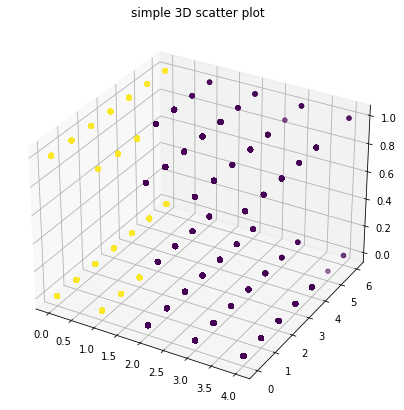

In [0]:

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
#colors = ['blue', 'green', 'red']



    

ax.scatter3D(predictions.select("AGE_GROUP_index").toPandas().values, predictions.select("PERP_RACE_index").toPandas().values, predictions.select("PERP_SEX_index").toPandas().values, c =predictions.select("prediction").toPandas().values)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

0
0.5267681974461154
0.6753112738473919
0.5346891553767291
0.5160935437524249
0.5657556803888971
0.529900759895806
0.5924759157634063
0.6071302344668646


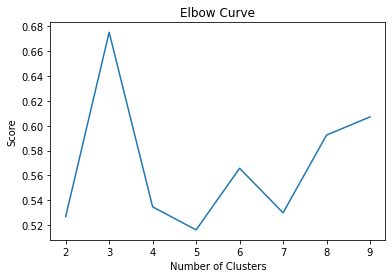

In [0]:
import numpy as np
import pandas as pd
silho = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(dfArrestsAssemble)
    predictions = model.transform(dfArrestsAssemble)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silho[k]=silhouette

# Plot the cost
df_silho = pd.DataFrame(silho[2:])
display(df_silho)
df_silho.columns = ["silho"]
new_col = [2,3,4,5,6,7,8, 9]
df_silho.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_silho.cluster, df_silho.silho)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

##Con k=6

In [0]:
kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(dfArrestsAssemble)

In [0]:
predictions = model.transform(dfArrestsAssemble)
display(predictions)

AGE_GROUP,PERP_SEX,PERP_RACE,AGE_GROUP_index,PERP_RACE_index,PERP_SEX_index,features,prediction
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())",0
45-64,M,BLACK,1.0,0.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0))",0
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())",0
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())",0
18-24,F,BLACK,2.0,0.0,1.0,"Map(vectorType -> dense, length -> 3, values -> List(2.0, 1.0, 0.0))",4
25-44,M,BLACK,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())",0
25-44,F,BLACK,0.0,0.0,1.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0))",3
25-44,M,WHITE HISPANIC,0.0,1.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0))",5
25-44,M,WHITE,0.0,2.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0))",2
25-44,M,WHITE,0.0,2.0,0.0,"Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0))",2


In [0]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5657556803888971


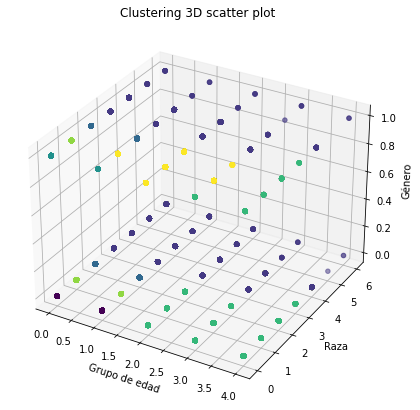

In [0]:

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
#colors = ['blue', 'green', 'red']



    

ax.scatter3D(predictions.select("AGE_GROUP_index").toPandas().values, predictions.select("PERP_RACE_index").toPandas().values, predictions.select("PERP_SEX_index").toPandas().values, c =predictions.select("prediction").toPandas().values)
plt.title("Clustering 3D scatter plot")
ax.set_xlabel('Grupo de edad')
ax.set_ylabel('Raza')
ax.set_zlabel("Género")
 
# show plot
plt.show()

#Con Poverty

In [0]:
dfPoverty.display()

SERIALNO,SPORDER,PWGTP,WGTP,AGEP,CIT,REL,SCH,SCHG,SCHL,SEX,ESR,LANX,ENG,MSP,MAR,WKW,WKHP,DIS,JWTR,NP,TEN,HHT,AgeCateg,Boro,CitizenStatus,EducAttain,EST_Childcare,EST_Commuting,EST_EITC,EST_FICAtax,EST_HEAP,EST_Housing,EST_IncomeTax,EST_MOOP,EST_Nutrition,EST_PovGap,EST_PovGapIndex,Ethnicity,FamType_PU,FTPTWork,INTP_adj,MRGP_adj,NYCgov_Income,NYCgov_Pov_Stat,NYCgov_REL,NYCgov_Threshold,Off_Pov_Stat,Off_Threshold,OI_adj,PA_adj,Povunit_ID,Povunit_Rel,PreTaxIncome_PU,RETP_adj,RNTP_adj,SEMP_adj,SSIP_adj,SSP_adj,TotalWorkHrs_PU,WAGP_adj
1,1,95,95,31,1,0,1,0,22,2,1,2,null,6,5,1,60,2,12,1,2,6,2,2,1,4,0.0,1722.0,0.0,9765.2422,0.0,1478.3278,33580.543,2642.8,0.0,0.0,0.0,4,8,1,0.0,0.0,81417.961,2,0,16241.6,2,13064,0.0,0.0,1,1,127650.22,0.0,0.0,0.0,0.0,0.0,2,127650.22
16,1,181,181,63,1,0,1,0,22,2,1,2,null,1,1,1,60,2,1,2,1,1,2,3,1,4,0.0,3840.8416,0.0,13950.346,0.0,0.0,95503.234,4766.7998,0.0,0.0,0.0,1,2,1,101309.7,2532.7424,228417.95,2,0,22900.654,2,16815,0.0,0.0,1,1,346479.19,0.0,0.0,0.0,0.0,0.0,2,182357.45
16,2,210,181,65,1,1,1,0,19,1,6,2,null,1,1,null,0,2,null,2,1,1,3,3,1,3,0.0,3840.8416,0.0,13950.346,0.0,0.0,95503.234,4766.7998,0.0,0.0,0.0,1,2,3,50654.852,2532.7424,228417.95,2,1,22900.654,2,16815,0.0,0.0,1,2,346479.19,0.0,0.0,0.0,0.0,12157.164,2,0.0
47,1,62,62,68,4,0,1,0,1,1,1,1,2,1,1,1,40,2,10,2,2,1,3,2,2,1,0.0,0.0,0.0,9765.2422,0.0,2612.8022,27574.365,3218.8,0.0,0.0,0.0,1,2,1,0.0,0.0,117058.23,2,0,22900.654,2,15178,0.0,0.0,1,1,155003.84,0.0,0.0,0.0,0.0,27353.619,1,91178.727
47,2,71,62,63,4,1,1,0,1,2,1,1,1,1,1,1,40,2,10,2,2,1,2,2,2,1,0.0,0.0,0.0,9765.2422,0.0,2612.8022,27574.365,3218.8,0.0,0.0,0.0,1,2,1,0.0,0.0,117058.23,2,1,22900.654,2,15178,0.0,0.0,1,2,155003.84,0.0,0.0,0.0,0.0,0.0,1,36471.492
55,1,430,430,29,5,0,1,0,21,2,6,1,3,1,1,1,40,2,null,3,3,1,2,4,3,4,0.0,4954.1665,0.0,2915.3896,0.0,0.0,1115.2131,0.0,0.0,3214.7793,0.14037937,4,2,1,0.0,0.0,19685.875,1,0,22900.654,2,16815,0.0,0.0,1,1,28670.645,0.0,2026.194,0.0,0.0,0.0,1,17526.578
55,2,466,430,25,5,1,1,0,21,1,1,1,1,1,1,1,40,2,1,3,3,1,2,4,3,4,0.0,4954.1665,0.0,2915.3896,0.0,0.0,1115.2131,0.0,0.0,3214.7793,0.14037937,4,2,1,0.0,0.0,19685.875,1,1,22900.654,2,16815,0.0,0.0,1,2,28670.645,0.0,2026.194,11144.067,0.0,0.0,1,0.0
55,3,453,430,32,1,15,1,0,16,1,1,1,1,6,5,1,40,2,1,3,3,1,2,4,1,2,0.0,6703.5,0.0,3875.0959,0.0,0.0,8213.8594,4176.96,0.0,0.0,0.0,4,7,1,0.0,0.0,27685.434,2,12,16241.6,2,13064,0.0,0.0,2,1,50654.852,0.0,2026.194,0.0,0.0,0.0,3,50654.852
194,1,201,201,76,4,0,1,0,21,1,6,2,null,3,2,null,0,2,null,1,3,4,3,2,2,4,0.0,0.0,0.0,0.0,0.0,0.0,1558.6013,1378.6801,0.0,0.0,0.0,2,8,3,405.2388,0.0,40727.199,2,0,16241.6,2,12043,0.0,0.0,1,1,43664.48,23402.541,891.52533,0.0,0.0,19856.701,5,0.0
218,1,55,56,46,5,0,1,0,17,2,1,1,4,1,1,1,35,2,4,2,3,1,2,2,3,2,0.0,1795.8,0.0,6122.6519,0.0,0.0,11775.876,9036.96,0.0,0.0,0.0,3,2,1,0.0,0.0,51303.375,2,0,22900.654,2,16815,0.0,0.0,1,1,80034.664,0.0,911.78729,0.0,0.0,0.0,2,70916.789


In [0]:
dfPovertyDemog = dfPoverty.select(col("TEN"),col("CitizenStatus"),col("Ethnicity"),col("FamType_PU"),col("NYCgov_Pov_Stat"),col("TotalWorkHrs_PU"),col("CIT"),col("MAR"),col("RNTP_adj"))
display(dfPovertyDemog.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfPovertyDemog.columns]))
display(dfPovertyDemog)
                                                 

TEN,CitizenStatus,Ethnicity,FamType_PU,NYCgov_Pov_Stat,TotalWorkHrs_PU,CIT,MAR,RNTP_adj
0,0,0,0,0,0,0,0,0


TEN,CitizenStatus,Ethnicity,FamType_PU,NYCgov_Pov_Stat,TotalWorkHrs_PU,CIT,MAR,RNTP_adj
2,1,4,8,2,2,1,5,0.0
1,1,1,2,2,2,1,1,0.0
1,1,1,2,2,2,1,1,0.0
2,2,1,2,2,1,4,1,0.0
2,2,1,2,2,1,4,1,0.0
3,3,4,2,1,1,5,1,2026.194
3,3,4,2,1,1,5,1,2026.194
3,1,4,7,2,3,1,5,2026.194
3,2,2,8,2,5,4,2,891.52533
3,3,3,2,2,2,5,1,911.78729


In [0]:
assemble=VectorAssembler(inputCols=[
 'TEN',
 'CitizenStatus',
 'Ethnicity',
  'FamType_PU',
    'NYCgov_Pov_Stat',
    'TotalWorkHrs_PU',
    'CIT',
    'MAR',
    'RNTP_adj']
, outputCol='features')
dfPovAssemble=assemble.transform(dfPovertyDemog)
display(dfPovAssemble)


TEN,CitizenStatus,Ethnicity,FamType_PU,NYCgov_Pov_Stat,TotalWorkHrs_PU,CIT,MAR,RNTP_adj,features
2,1,4,8,2,2,1,5,0.0,"Map(vectorType -> dense, length -> 9, values -> List(2.0, 1.0, 4.0, 8.0, 2.0, 2.0, 1.0, 5.0, 0.0))"
1,1,1,2,2,2,1,1,0.0,"Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0))"
1,1,1,2,2,2,1,1,0.0,"Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0))"
2,2,1,2,2,1,4,1,0.0,"Map(vectorType -> dense, length -> 9, values -> List(2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0))"
2,2,1,2,2,1,4,1,0.0,"Map(vectorType -> dense, length -> 9, values -> List(2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0))"
3,3,4,2,1,1,5,1,2026.194,"Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 4.0, 2.0, 1.0, 1.0, 5.0, 1.0, 2026.194))"
3,3,4,2,1,1,5,1,2026.194,"Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 4.0, 2.0, 1.0, 1.0, 5.0, 1.0, 2026.194))"
3,1,4,7,2,3,1,5,2026.194,"Map(vectorType -> dense, length -> 9, values -> List(3.0, 1.0, 4.0, 7.0, 2.0, 3.0, 1.0, 5.0, 2026.194))"
3,2,2,8,2,5,4,2,891.52533,"Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 2.0, 8.0, 2.0, 5.0, 4.0, 2.0, 891.52533))"
3,3,3,2,2,2,5,1,911.78729,"Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 5.0, 1.0, 911.78729))"


0
0.797268482005341
0.8487156016741018
0.8377414733593608
0.824690063223422
0.8196652122219158
0.8255826771031156
0.8218863029849081
0.8345041479206948


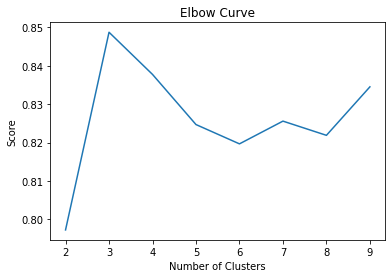

In [0]:
import numpy as np
import pandas as pd
silho = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(dfPovAssemble)
    predictions = model.transform(dfPovAssemble)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silho[k]=silhouette

# Plot the cost
df_silho = pd.DataFrame(silho[2:])
display(df_silho)
df_silho.columns = ["silho"]
new_col = [2,3,4,5,6,7,8, 9]
df_silho.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_silho.cluster, df_silho.silho)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

##Con k = 7

In [0]:
kmeans = KMeans().setK(7).setSeed(1)
model = kmeans.fit(dfPovAssemble)

In [0]:
predictions = model.transform(dfPovAssemble)
display(predictions)

TEN,CitizenStatus,Ethnicity,FamType_PU,NYCgov_Pov_Stat,TotalWorkHrs_PU,CIT,MAR,RNTP_adj,features,prediction
2,1,4,8,2,2,1,5,0.0,"Map(vectorType -> dense, length -> 9, values -> List(2.0, 1.0, 4.0, 8.0, 2.0, 2.0, 1.0, 5.0, 0.0))",1
1,1,1,2,2,2,1,1,0.0,"Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0))",1
1,1,1,2,2,2,1,1,0.0,"Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0))",1
2,2,1,2,2,1,4,1,0.0,"Map(vectorType -> dense, length -> 9, values -> List(2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0))",1
2,2,1,2,2,1,4,1,0.0,"Map(vectorType -> dense, length -> 9, values -> List(2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0))",1
3,3,4,2,1,1,5,1,2026.194,"Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 4.0, 2.0, 1.0, 1.0, 5.0, 1.0, 2026.194))",2
3,3,4,2,1,1,5,1,2026.194,"Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 4.0, 2.0, 1.0, 1.0, 5.0, 1.0, 2026.194))",2
3,1,4,7,2,3,1,5,2026.194,"Map(vectorType -> dense, length -> 9, values -> List(3.0, 1.0, 4.0, 7.0, 2.0, 3.0, 1.0, 5.0, 2026.194))",2
3,2,2,8,2,5,4,2,891.52533,"Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 2.0, 8.0, 2.0, 5.0, 4.0, 2.0, 891.52533))",4
3,3,3,2,2,2,5,1,911.78729,"Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 5.0, 1.0, 911.78729))",4


Output can only be rendered in Databricks

Output can only be rendered in Databricks

Output can only be rendered in Databricks

In [0]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.8255826771031156
